# Loading data


In [0]:
# Imports
from sklearn.datasets import load_files
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer 
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
import time
from sklearn.datasets import fetch_20newsgroups
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
import numpy as np
import matplotlib.pyplot as plt

In [0]:
# Get the Imdb data (will go in Colab's "content" folder)
# Must run this once per 12 hours (files deleted from Colab's memory)
! git clone https://gitlab.com/formenli/aclimdbdata.git

Cloning into 'aclimdbdata'...
remote: Enumerating objects: 98534, done.
remote: Counting objects: 100% (98534/98534), done.
remote: Compressing objects: 100% (98513/98513), done.
remote: Total 98534 (delta 25), reused 98514 (delta 13), pack-reused 0
Receiving objects: 100% (98534/98534), 94.86 MiB | 10.05 MiB/s, done.
Resolving deltas: 100% (25/25), done.
Checking out files: 100% (50030/50030), done.


In [0]:
# Load Imdb data. Takes in path to directory containing sub dirs that contain data of each output class respectively.
# Outputs a dict-like object, where .data is the data, .targets are the output classes, and .target_names is a list
# of the names given to each target (where the number corresponds to the index)
imdbTrain = load_files("aclimdbdata/train/")
imdbTest = load_files("aclimdbdata/test/")

In [0]:
# Load subsets for debugging
imdbSubsetTrain = load_files("aclimdbdata/subsetTrain/")

# Multinomial NB on Imdb

In [0]:
# Preliminary playing with the Imdb data, Multinomial Naive Bayes fit
# NB often used as a baseline because no hyperparams to tune.

text_clf = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', MultinomialNB()),
    ])
text_clf.fit(imdbTrain.data, imdbTrain.target)

# Predict 
predicted = text_clf.predict(imdbTest.data)
accuracy_score(imdbTest.target, predicted)    

0.82956

# Logistic regression on Imdb

In [0]:
# SKLearn default logistic regression
# Penalty: l2
# Solver lbfgs
# Inverse reg strength (C): 1.0

default_LR_clf = Pipeline([
                           ('vect', CountVectorizer()),
                           ('tfidf', TfidfTransformer()),
                           ('clf', LogisticRegression()),
])

LR_imdb_default_results = cross_validate(default_LR_clf, imdbTrain.data, imdbTrain.target, return_train_score=True, cv=5, n_jobs=-1, verbose=1)
print('CV accuracy: ', np.mean(LR_imdb_default_results['test_score']))
print('Mean fit time: ', np.mean(LR_imdb_default_results['fit_time']))
print('Train acc: ', np.mean(LR_imdb_default_results['train_score']))

start = time.time()
default_LR_clf.fit(imdbTrain.data, imdbTrain.target)
print('Train time:', time.time() - start)
# Training accuracy
trainPredictions = default_LR_clf.predict(imdbTrain.data)
print('Train accuracy: ', accuracy_score(imdbTrain.target, trainPredictions))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  2.1min finished


CV accuracy:  0.7248545294639129
Mean fit time:  42.02966232299805
Train acc:  0.910243944402449
Train time: 5.501657485961914
Train accuracy:  0.93328


In [0]:
# Grid search of non continuous parameters
# Only sensible combinations
# Group 1: penalty=l2,none; solvers=lbfgs, newton-cg, sag, saga

# Build pipeline
LR1_clf = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', LogisticRegression()),
])
# Params for grid search
params = {'clf__penalty': ('l2','none'),
          'clf__C': (0.001, 0.1, 1, 10),
          'clf__solver': ('lbfgs', 'newton-cg', 'sag', 'saga')}

LR1_gs_clf = GridSearchCV(LR1_clf, params, n_jobs=-1, return_train_score=True)
LR1_gs_clf.fit(imdbTrain.data, imdbTrain.target)

for param_name in sorted(params.keys()):
  print("%s : %r" % (param_name, LR1_gs_clf.best_params_[param_name]))
print('Train time for best params:', LR1_gs_clf.cv_results_['mean_fit_time'][LR1_gs_clf.best_index_])
print('Train acc for best params:', LR1_gs_clf.cv_results_['mean_train_score'][LR1_gs_clf.best_index_])
print('CV acc for best params:', LR1_gs_clf.best_score_)

# Check how the best performs:
LR1_best_clf = Pipeline([
                         ('vect', CountVectorizer()),
                         ('tfidf', TfidfTransformer()),
                         ('clf', LogisticRegression(penalty=LR1_gs_clf.best_params_['clf__penalty'],
                                           solver=LR1_gs_clf.best_params_['clf__solver'],
                                           C=LR1_gs_clf.best_params_['clf__C']))
])

start = time.time()
LR1_best_clf.fit(imdbTrain.data, imdbTrain.target)
print('Train time:', time.time()-start)
# Train acc
trainPreds = LR1_best_clf.predict(imdbTrain.data)
print('Train acc:', accuracy_score(trainPreds, imdbTrain.target))

clf__C : 10
clf__penalty : 'l2'
clf__solver : 'newton-cg'
Train time for best params: 8.83703408241272
Train acc for best params: 0.9895900000000001
CV acc for best params: 0.8945599999999999
Train time: 8.308072328567505
Train acc: 0.98764


In [0]:
# Exploring group 1 results a little more fully
for p, t, r in zip(LR1_gs_clf.cv_results_['params'], LR1_gs_clf.cv_results_['mean_fit_time'], LR1_gs_clf.cv_results_['mean_test_score']):
  print(p,t,r)
# Output shows that essentially lbfgs and newton-cg come out with the same acc but lbfgs is consistently faster => preferred.

{'clf__C': 0.001, 'clf__penalty': 'l2', 'clf__solver': 'lbfgs'} 5.338502073287964 0.76908
{'clf__C': 0.001, 'clf__penalty': 'l2', 'clf__solver': 'newton-cg'} 5.825904798507691 0.76908
{'clf__C': 0.001, 'clf__penalty': 'l2', 'clf__solver': 'sag'} 7.357763147354126 0.76956
{'clf__C': 0.001, 'clf__penalty': 'l2', 'clf__solver': 'saga'} 7.315402221679688 0.7696799999999999
{'clf__C': 0.001, 'clf__penalty': 'none', 'clf__solver': 'lbfgs'} 7.226515674591065 0.8788
{'clf__C': 0.001, 'clf__penalty': 'none', 'clf__solver': 'newton-cg'} 10.254513788223267 0.87748
{'clf__C': 0.001, 'clf__penalty': 'none', 'clf__solver': 'sag'} 10.751192045211791 0.88484
{'clf__C': 0.001, 'clf__penalty': 'none', 'clf__solver': 'saga'} 11.900542497634888 0.88644
{'clf__C': 0.1, 'clf__penalty': 'l2', 'clf__solver': 'lbfgs'} 5.85276689529419 0.84856
{'clf__C': 0.1, 'clf__penalty': 'l2', 'clf__solver': 'newton-cg'} 6.863955497741699 0.84856
{'clf__C': 0.1, 'clf__penalty': 'l2', 'clf__solver': 'sag'} 5.843652582168579 

In [0]:
# Grid search of non continuous parameters
# Only sensible combinations
# Group 2: solver=liblinear, penalty = l2,l1, dual = False

# Build pipeline
LR2_clf = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', LogisticRegression(solver='liblinear', dual=False)),
])
# Params for grid search
params = {'clf__penalty': ('l2','l1'),
          'clf__C': (0.001, 0.1, 1, 5, 10, 15)}

# njobs=1 here to stop parallel processing - causes memory leaks for this solver
# https://github.com/ageron/handson-ml/issues/315 
LR2_gs_clf = GridSearchCV(LR2_clf, params, n_jobs=1, return_train_score=True)
LR2_gs_clf.fit(imdbTrain.data, imdbTrain.target)

for param_name in sorted(params.keys()):
  print("%s : %r" % (param_name, LR2_gs_clf.best_params_[param_name]))
print('Train time for best params:', LR2_gs_clf.cv_results_['mean_fit_time'][LR2_gs_clf.best_index_])
print('Train acc for best params:', LR2_gs_clf.cv_results_['mean_train_score'][LR2_gs_clf.best_index_])
print('CV acc for best params:', LR2_gs_clf.best_score_)

# Check how the best performs:
LR2_best_clf = Pipeline([
                         ('vect', CountVectorizer()),
                         ('tfidf', TfidfTransformer()),
                         ('clf', LogisticRegression(penalty=LR2_gs_clf.best_params_['clf__penalty'],
                                           solver='liblinear',
                                           dual=False,
                                           C=LR2_gs_clf.best_params_['clf__C']))
])

start = time.time()
LR2_best_clf.fit(imdbTrain.data, imdbTrain.target)
print('Train time:', time.time()-start)
# Train acc
trainPreds = LR2_best_clf.predict(imdbTrain.data)
print('Train acc:', accuracy_score(trainPreds, imdbTrain.target))

clf__C : 10
clf__penalty : 'l2'
Train time for best params: 5.303345966339111
Train acc for best params: 0.9895900000000001
CV acc for best params: 0.8945599999999999
Train time: 6.503049373626709
Train acc: 0.98764


In [0]:
# Grid search of non continuous parameters
# Only sensible combinations
# Group 3: solver=liblinear, penalty = l2, dual = True 

# Build pipeline
LR3_clf = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', LogisticRegression(solver='liblinear', dual=True, penalty='l2')),
])
# Params for grid search
params = {'clf__C': (0.001, 0.1, 1, 5, 10, 15)}

LR3_gs_clf = GridSearchCV(LR3_clf, params, n_jobs=-1, return_train_score=True)
LR3_gs_clf.fit(imdbTrain.data, imdbTrain.target)

for param_name in sorted(params.keys()):
  print("%s : %r" % (param_name, LR3_gs_clf.best_params_[param_name]))
print('Train time for best params:', LR3_gs_clf.cv_results_['mean_fit_time'][LR3_gs_clf.best_index_])
print('Train acc for best params:', LR3_gs_clf.cv_results_['mean_train_score'][LR3_gs_clf.best_index_])
print('CV acc for best params:', LR3_gs_clf.best_score_)

# Check how the best performs:
LR3_best_clf = Pipeline([
                         ('vect', CountVectorizer()),
                         ('tfidf', TfidfTransformer()),
                         ('clf', LogisticRegression(penalty='l2',
                                           solver='liblinear',
                                           dual=True,
                                           C=LR3_gs_clf.best_params_['clf__C']))
])

start = time.time()
LR3_best_clf.fit(imdbTrain.data, imdbTrain.target)
print('Train time:', time.time()-start)
# Train acc
trainPreds = LR3_best_clf.predict(imdbTrain.data)
print('Train acc:', accuracy_score(trainPreds, imdbTrain.target))

clf__C : 10
Train time for best params: 6.603286170959473
Train acc for best params: 0.9895900000000001
CV acc for best params: 0.8945599999999999
Train time: 4.774367570877075
Train acc: 0.98764


In [0]:
# Grid search of non continuous parameters
# Only sensible combinations
# Group 4: solver=saga, penalty = l1
# Took forever, ditched it

# Build pipeline
LR4_clf = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', LogisticRegression(solver='saga', penalty='l1', max_iter=1500)),
])
# From first run, saga needs more iterations
# Params for grid search
params = {'clf__C': (0.001, 0.1, 1, 5, 10, 15)}

LR4_gs_clf = GridSearchCV(LR4_clf, params, n_jobs=-1, return_train_score=True)
LR4_gs_clf.fit(imdbTrain.data, imdbTrain.target)

for param_name in sorted(params.keys()):
  print("%s : %r" % (param_name, LR4_gs_clf.best_params_[param_name]))
print('Train time for best params:', LR4_gs_clf.cv_results_['mean_fit_time'][LR4_gs_clf.best_index_])
print('Train acc for best params:', LR4_gs_clf.cv_results_['mean_train_score'][LR4_gs_clf.best_index_])
print('CV acc for best params:', LR4_gs_clf.best_score_)

# Check how the best performs:
LR4_best_clf = Pipeline([
                         ('vect', CountVectorizer()),
                         ('tfidf', TfidfTransformer()),
                         ('clf', LogisticRegression(penalty='l1',
                                           solver='saga',
                                           C=LR4_gs_clf.best_params_['clf__C']))
])

start = time.time()
LR4_best_clf.fit(imdbTrain.data, imdbTrain.target)
print('Train time:', time.time()-start)
# Train acc
trainPreds = LR4_best_clf.predict(imdbTrain.data)
print('Train acc:', accuracy_score(trainPreds, imdbTrain.target))

In [0]:
# Finer grid search
# Decided group three was best because faster but same results as group 1
# liblinear, C ~= 10, penalty = l2

# Build pipeline
LR3_clf = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', LogisticRegression(solver='liblinear', dual=True, penalty='l2')),
])
# Params for grid search
params = {'clf__C': (1.0, 2.5, 5.0,6.0,7.0,8.0,9.0,9.5,10,10.5,11)}

LR3_gs_clf = GridSearchCV(LR3_clf, params, n_jobs=-1, return_train_score=True)
LR3_gs_clf.fit(imdbTrain.data, imdbTrain.target)

for param_name in sorted(params.keys()):
  print("%s : %r" % (param_name, LR3_gs_clf.best_params_[param_name]))
print('Train time for best params:', LR3_gs_clf.cv_results_['mean_fit_time'][LR3_gs_clf.best_index_])
print('Train acc for best params:', LR3_gs_clf.cv_results_['mean_train_score'][LR3_gs_clf.best_index_])
print('CV acc for best params:', LR3_gs_clf.best_score_)

# Check how the best performs:
LR3_best_clf = Pipeline([
                         ('vect', CountVectorizer()),
                         ('tfidf', TfidfTransformer()),
                         ('clf', LogisticRegression(penalty='l2',
                                           solver='liblinear',
                                           dual=True,
                                           C=LR3_gs_clf.best_params_['clf__C']))
])

start = time.time()
LR3_best_clf.fit(imdbTrain.data, imdbTrain.target)
print('Train time:', time.time()-start)
# Train acc
trainPreds = LR3_best_clf.predict(imdbTrain.data)
print('Train acc:', accuracy_score(trainPreds, imdbTrain.target))

clf__C : 8.0
Train time for best params: 6.687569856643677
Train acc for best params: 0.9857700000000001
CV acc for best params: 0.89496
Train time: 4.922297477722168
Train acc: 0.98364


In [0]:
# on the test set
LR_imdb_best = Pipeline([
                         ('vect', CountVectorizer()),
                         ('tfidf', TfidfTransformer()),
                         ('clf', LogisticRegression(penalty='l2',
                                           solver='liblinear',
                                           dual=True,
                                           C=8.0))
])
LR_imdb_best.fit(imdbTrain.data, imdbTrain.target)
LRimdbBestPreds = LR_imdb_best.predict(imdbTest.data)
print("LR Imdb accuracy: ", accuracy_score(imdbTest.target, LRimdbBestPreds))


LR Imdb accuracy:  0.88224


{'clf__C': 1.0} 0.88832
{'clf__C': 2.5} 0.8938
{'clf__C': 5.0} 0.8943199999999999
{'clf__C': 6.0} 0.8946
{'clf__C': 7.0} 0.8948
{'clf__C': 8.0} 0.89496
{'clf__C': 9.0} 0.8947999999999998
{'clf__C': 9.5} 0.8946799999999999
{'clf__C': 10} 0.8945599999999999
{'clf__C': 10.5} 0.89444
{'clf__C': 11} 0.8943199999999999


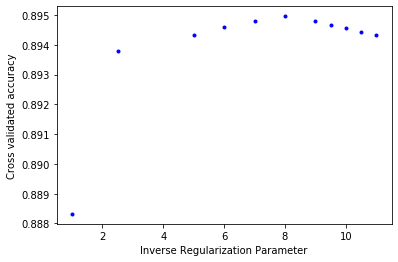

In [0]:
# Looking at CV results mean acc for all C
# Made a plot to show why its not worth tuning C anymore.
%matplotlib inline 
cs = []
cvAccs = []
LR_imdb_cplot_clf = Pipeline([
                              ('vect', CountVectorizer()),
                              ('tfidf', TfidfTransformer()),
                              ('clf', LogisticRegression(penalty='l2', solver='liblinear', dual=True))
])
params = {'clf__C': (1.0, 2.5, 5.0,6.0,7.0,8.0,9.0,9.5,10,10.5,11)}
LR_imdb_cplot_gs = GridSearchCV(LR_imdb_cplot_clf, params, n_jobs=1) 
LR_imdb_cplot_gs.fit(imdbTrain.data, imdbTrain.target)
for p, r in zip(LR_imdb_cplot_gs.cv_results_['params'], LR_imdb_cplot_gs.cv_results_['mean_test_score']):
    print(p,r)
    cs.append(p['clf__C'])
    cvAccs.append(r)
fig = plt.figure()
plt.plot(cs, cvAccs, 'b.')
plt.xlabel('Inverse Regularization Parameter')
plt.ylabel('Cross validated accuracy')
plt.savefig('imdbCTunePlot', dpi=400)

# SVM on Imdb

In [0]:
# Default parameters
# SKLearn default logistic regression
# Penalty: l2
# loss: squared hinge
# Inverse reg strength (C): 1.0
# Dual: True

SVC_imdb_default_clf = Pipeline([
                           ('vect', CountVectorizer()),
                           ('tfidf', TfidfTransformer()),
                           ('clf', LinearSVC()),
])

SVC_imdb_default_results = cross_validate(SVC_imdb_default_clf, twentyTrain.data, twentyTrain.target, return_train_score=True, cv=5, n_jobs=-1, verbose=1)
print('CV accuracy: ', np.mean(SVC_imdb_default_results['test_score']))
print('Mean fit time: ', np.mean(SVC_imdb_default_results['fit_time']))
print('Train acc: ', np.mean(SVC_imdb_default_results['train_score']))

start = time.time()
SVC_imdb_default_clf.fit(imdbTrain.data, imdbTrain.target)
print('Train time:', time.time() - start)
# Training accuracy
trainPredictions = SVC_imdb_default_clf.predict(imdbTrain.data)
print('Train accuracy: ', accuracy_score(imdbTrain.target, trainPredictions))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   17.2s finished


CV accuracy:  0.7610048318918143
Mean fit time:  3.7774492740631103
Train acc:  0.973462081835768
Train time: 3.9543659687042236
Train accuracy:  0.98996


In [0]:
# Grid search SVC on Imdb
# dual = False, loss=squared_hinge (loss=hinge does not work with dual=False)

# Build pipeline
SVC_clf = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', LinearSVC(dual=False, loss='squared_hinge')),
])
# 'clf__penalty': ('l2', 'l1'),
# Params for main grid search
params = {'clf__penalty': ('l2','l1'),
          'clf__C': (0.01, 0.1, 0.5, 1.0, 2, 5, 10, 100)}

SVC_gs_clf = GridSearchCV(SVC_clf, params, n_jobs=-1, return_train_score=True)
SVC_gs_clf.fit(imdbTrain.data, imdbTrain.target)
# Figuring out what these params are
# print(SVC_gs_clf.cv_results_)
# print(SVC_gs_clf.best_score_)
# print(SVC_gs_clf.best_params_)
# print(SVC_gs_clf.best_index_)
# print(SVC_gs_clf.cv_results_['mean_test_score'][SVC_gs_clf.best_index_])

for param_name in sorted(params.keys()):
  print("%s : %r" % (param_name, SVC_gs_clf.best_params_[param_name]))
print('Train time for best params:', SVC_gs_clf.cv_results_['mean_fit_time'][SVC_gs_clf.best_index_])
print('Train acc for best params:', SVC_gs_clf.cv_results_['mean_train_score'][SVC_gs_clf.best_index_])
print('CV acc for best params:', SVC_gs_clf.best_score_)

# Check how the best performs:
SVC_best_clf = Pipeline([
                         ('vect', CountVectorizer()),
                         ('tfidf', TfidfTransformer()),
                         ('clf', LinearSVC(penalty=SVC_gs_clf.best_params_['clf__penalty'],
                                           loss='squared_hinge',
                                           dual=False,
                                           C=SVC_gs_clf.best_params_['clf__C']))
])

start = time.time()
SVC_best_clf.fit(imdbTrain.data, imdbTrain.target)
print('Train time:', time.time()-start)
# Train acc
trainPreds = SVC_best_clf.predict(imdbTrain.data)
print('Train acc:', accuracy_score(trainPreds, imdbTrain.target))

clf__C : 0.5
clf__penalty : 'l2'
Train time for best params: 6.828944826126099
Train acc for best params: 0.98001
CV acc for best params: 0.8950799999999999
Train time: 5.137102127075195
Train acc: 0.97808


In [0]:
# Grid search SVC on Imdb
# dual = True, penalty=l2

# Build pipeline
SVC_clf = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', LinearSVC(dual=True, penalty='l2'))
])
# Params for main grid search
params = {'clf__loss': ('hinge','squared_hinge'),
          'clf__C': (0.01, 0.1, 0.5, 1.0, 2.0, 5.0, 10, 100)}

SVC_gs_clf = GridSearchCV(SVC_clf, params, n_jobs=-1, return_train_score=True)
SVC_gs_clf.fit(imdbTrain.data, imdbTrain.target)
for param_name in sorted(params.keys()):
  print("%s : %r" % (param_name, SVC_gs_clf.best_params_[param_name]))
print('Train time for best params:', SVC_gs_clf.cv_results_['mean_fit_time'][SVC_gs_clf.best_index_])
print('Train acc for best params:', SVC_gs_clf.cv_results_['mean_train_score'][SVC_gs_clf.best_index_])
print('CV acc for best params:', SVC_gs_clf.best_score_)

# Check how the best performs:
SVC_best_clf = Pipeline([
                         ('vect', CountVectorizer()),
                         ('tfidf', TfidfTransformer()),
                         ('clf', LinearSVC(penalty='l2',
                                           loss=SVC_gs_clf.best_params_['clf__loss'],
                                           dual=True,
                                           C=SVC_gs_clf.best_params_['clf__C']))
])

start = time.time()
SVC_best_clf.fit(imdbTrain.data, imdbTrain.target)
print('Train time:', time.time()-start)
# Train acc
trainPreds = SVC_best_clf.predict(imdbTrain.data)
print('Train acc:', accuracy_score(trainPreds, imdbTrain.target))

clf__C : 0.5
clf__loss : 'squared_hinge'
Train time for best params: 5.540150880813599
Train acc for best params: 0.98001
CV acc for best params: 0.8950799999999999
Train time: 3.9649925231933594
Train acc: 0.97808


In [0]:
# Fine search for inverse reg param with best params otherwise
# penalty=l2, dual=true since results l2 always on top, and results don't change with dual, only train time
# Build pipeline
SVC_clf = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', LinearSVC(dual=True, penalty='l2'))
])
# Params for main grid search
params = {'clf__loss': ('hinge','squared_hinge'),
          'clf__C': (0.2, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.7, 0.8)}

SVC_gs_clf = GridSearchCV(SVC_clf, params, n_jobs=-1, return_train_score=True)
SVC_gs_clf.fit(imdbTrain.data, imdbTrain.target)
for param_name in sorted(params.keys()):
  print("%s : %r" % (param_name, SVC_gs_clf.best_params_[param_name]))
print('Train time for best params:', SVC_gs_clf.cv_results_['mean_fit_time'][SVC_gs_clf.best_index_])
print('Train acc for best params:', SVC_gs_clf.cv_results_['mean_train_score'][SVC_gs_clf.best_index_])
print('CV acc for best params:', SVC_gs_clf.best_score_)

# Check how the best performs:
SVC_best_clf = Pipeline([
                         ('vect', CountVectorizer()),
                         ('tfidf', TfidfTransformer()),
                         ('clf', LinearSVC(penalty='l2',
                                           loss=SVC_gs_clf.best_params_['clf__loss'],
                                           dual=True,
                                           C=SVC_gs_clf.best_params_['clf__C']))
])

start = time.time()
SVC_best_clf.fit(imdbTrain.data, imdbTrain.target)
print('Train time:', time.time()-start)
# Train acc
trainPreds = SVC_best_clf.predict(imdbTrain.data)
print('Train acc:', accuracy_score(trainPreds, imdbTrain.target))

clf__C : 0.55
clf__loss : 'squared_hinge'
Train time for best params: 5.555875682830811
Train acc for best params: 0.9821100000000001
CV acc for best params: 0.89544
Train time: 3.727783203125
Train acc: 0.97996


{'clf__C': 0.2, 'clf__loss': 'squared_hinge'} 0.89448
{'clf__C': 0.3, 'clf__loss': 'squared_hinge'} 0.8952
{'clf__C': 0.35, 'clf__loss': 'squared_hinge'} 0.89512
{'clf__C': 0.4, 'clf__loss': 'squared_hinge'} 0.8950400000000001
{'clf__C': 0.45, 'clf__loss': 'squared_hinge'} 0.89528
{'clf__C': 0.5, 'clf__loss': 'squared_hinge'} 0.8950799999999999
{'clf__C': 0.55, 'clf__loss': 'squared_hinge'} 0.89544
{'clf__C': 0.6, 'clf__loss': 'squared_hinge'} 0.8952
{'clf__C': 0.7, 'clf__loss': 'squared_hinge'} 0.89416
{'clf__C': 0.8, 'clf__loss': 'squared_hinge'} 0.8935600000000001


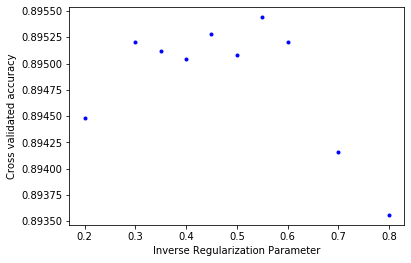

In [0]:
# Looking at CV results mean acc for all C
# Made a plot to show why its not worth tuning C anymore.
%matplotlib inline 
cs = []
cvAccs = []
for p, r in zip(SVC_gs_clf.cv_results_['params'], SVC_gs_clf.cv_results_['mean_test_score']):
  if p['clf__loss'] != 'hinge':
    print(p,r)
    cs.append(p['clf__C'])
    cvAccs.append(r)
fig = plt.figure()
plt.plot(cs, cvAccs, 'b.')
plt.xlabel('Inverse Regularization Parameter')
plt.ylabel('Cross validated accuracy')
plt.savefig('imdbCTunePlot', dpi=400)

In [0]:
# Tuning Count Vec and tfidf, imdb
SVC_imdb_feat_tune = Pipeline([
                        ('vect', CountVectorizer()),
                        ('tfidf', TfidfTransformer()),
                        ('clf', LinearSVC(penalty='l2', dual=True, loss='squared_hinge'))                            
])
params = {'vect__ngram_range': ((1,1), (1,2)),
         'vect__max_df': (0.2, 0.4, 0.6, 0.8, 1.0),
          'tfidf__sublinear_tf': (True, False),
         'clf__C': (0.01, 0.1, 1.0, 10, 20)}

SVC_imdb_feat_tune_gs = GridSearchCV(SVC_imdb_feat_tune, params, return_train_score=True)
SVC_imdb_feat_tune_gs.fit(imdbTrain.data, imdbTrain.target) 

for param_name in sorted(params.keys()):
  print("%s : %r" % (param_name, SVC_imdb_feat_tune_gs.best_params_[param_name]))

print('Train time for best params:', SVC_imdb_feat_tune_gs.cv_results_['mean_fit_time'][SVC_imdb_feat_tune_gs.best_index_])
print('Train acc for best params:', SVC_imdb_feat_tune_gs.cv_results_['mean_train_score'][SVC_imdb_feat_tune_gs.best_index_])
print('CV acc for best params:', SVC_imdb_feat_tune_gs.best_score_)

# Check how the best performs:
SVC_imdb_feat_tune_best = Pipeline([
                         ('vect', CountVectorizer(ngram_range=SVC_imdb_feat_tune_gs.best_params_['vect__ngram_range'],
                                                  max_df=SVC_imdb_feat_tune_gs.best_params_['vect__max_df'])),
                         ('tfidf', TfidfTransformer(sublinear_tf=SVC_imdb_feat_tune_gs.best_params_['tfidf__sublinear_tf'])),
                         ('clf', LinearSVC(penalty='l2',
                                           loss='squared_hinge',
                                           dual=True,
                                           C=SVC_imdb_feat_tune_gs.best_params_['clf__C']))
])

start = time.time()
SVC_imdb_feat_tune_best.fit(imdbTrain.data, imdbTrain.target)
print('Train time:', time.time()-start)
# Train acc
trainPreds = SVC_imdb_feat_tune_best.predict(imdbTrain.data)
print('Train acc:', accuracy_score(trainPreds, imdbTrain.target))

clf__C : 1.0
tfidf__sublinear_tf : True
vect__max_df : 0.2
vect__ngram_range : (1, 2)
Train time for best params: 14.008985948562621
Train acc for best params: 0.9999600000000001
CV acc for best params: 0.9110799999999999
Train time: 17.62760066986084
Train acc: 0.99996


In [0]:
# Using the best model with feature selection on the test set
SVC_imdb_best = Pipeline([
                         ('vect', CountVectorizer(max_df=0.2, ngram_range=(1,2))),
                         ('tfidf', TfidfTransformer(sublinear_tf=True)),
                         ('clf', LinearSVC(penalty='l2', dual=True, loss='squared_hinge', C=1.0)) 
])
SVC_imdb_best.fit(imdbTrain.data, imdbTrain.target)
imdbTestPreds = SVC_imdb_best.predict(imdbTest.data)
print('Test acc:', accuracy_score(imdbTestPreds, imdbTest.target))

Test acc: 0.90664


# Studying new feature design, imdb

In [0]:
# Performing first two steps of pipeline separately to be able to study them.
# First, look at new feature design
CountVec = CountVectorizer(max_df=0.2, ngram_range=(1,2))
imdbTrain_count = CountVec.fit_transform(imdbTrain.data)
tfidfVec = TfidfTransformer(sublinear_tf=True).fit(imdbTrain_count)
imdbTrain_tfidf = tfidfVec.transform(imdbTrain_count)
print('New design shape:', imdbTrain_tfidf.shape)
# Now, look at default
CountVec_def = CountVectorizer()
imdbTrain_count_def = CountVec_def.fit_transform(imdbTrain.data)
tfidfVec_def = TfidfTransformer().fit(imdbTrain_count_def)
imdbTrain_tfidf_def = tfidfVec_def.transform(imdbTrain_count_def)
print('Default shape:', imdbTrain_tfidf_def.shape)

New design shape: (25000, 1513704)
Default shape: (25000, 74849)


# Load 20 Newsgroups

In [0]:
# Load 20 newsgroups
twentyTrain = fetch_20newsgroups(subset='train', remove=(['headers', 'footers', 'quotes']))
twentyTest = fetch_20newsgroups(subset='test', remove=(['headers', 'footers', 'quotes']))

In [0]:
# Create validation set for quick tests before running CV or grid search strategies by splitting the train set
# Control random state so for all group members split will be the same - good for comparing accuracies
x20Train, x20Val, y20Train, y20Val = train_test_split(twentyTrain.data, twentyTrain.target, test_size=0.2, random_state=1)
print(y20Train.shape, y20Val.shape)

(9051,) (2263,)


# LR on 20 newsgroups

In [0]:
# Default LR parameters
# Also increased max_iters

lbfgs_default_clf = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', LogisticRegression(max_iter=1000, verbose=True)),
])

results = cross_validate(lbfgs_default_clf, twentyTrain.data, twentyTrain.target, return_train_score=True, cv=5, n_jobs=-1, verbose=1)
print('CV accuracy: ', np.mean(results['test_score']))
print('Mean fit time: ', np.mean(results['fit_time']))
print('Train acc: ', np.mean(results['train_score']))

# Get train time with full dataset
start = time.time()
lbfgs_default_clf.fit(twentyTrain.data, twentyTrain.target)
print('Train time:', time.time()-start)
# Train acc
trainPreds = lbfgs_default_clf.predict(twentyTrain.data)
print('Train acc:', accuracy_score(trainPreds, twentyTrain.target))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  2.1min finished


CV accuracy:  0.7248545294639129
Mean fit time:  41.89269018173218
Train acc:  0.910243944402449


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   34.9s finished


Train time: 36.390690326690674
Train acc: 0.907371398267633


In [0]:
# Chose lbfgs solver (all solvers essentially the same on Imdb, and this one has a real multiclass classification option unlike liblinear)
# Group 1: lbfgs, penalty = none
# Penalty = none

lbfgs_none_clf = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', LogisticRegression(solver='lbfgs', penalty='none', max_iter=1000, verbose=True, n_jobs=-1)),
])

results = cross_validate(lbfgs_none_clf, twentyTrain.data, twentyTrain.target, return_train_score=True, cv=5, n_jobs=-1, verbose=1)
print('CV accuracy: ', np.mean(results['test_score']))
print('Mean fit time: ', np.mean(results['fit_time']))
print('Train acc: ', np.mean(results['train_score']))

# Get train time with full dataset
start = time.time()
lbfgs_none_clf.fit(twentyTrain.data, twentyTrain.target)
print('Train time:', time.time()-start)
# Train acc
trainPreds = lbfgs_none_clf.predict(twentyTrain.data)
print('Train acc:', accuracy_score(trainPreds, twentyTrain.target))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  9.3min finished


CV accuracy:  0.722468589968247
Mean fit time:  195.81416606903076
Train acc:  0.974854163911254


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:  1.8min finished


Train time: 108.85000467300415
Train acc: 0.9747215838783808


In [0]:
# Chose lbfgs solver (all solvers essentially the same on Imdb, and this one has a real multiclass classification option unlike liblinear)
# Group 1: lbfgs, penalty = l2

lbfgs_l2_clf = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', LogisticRegression(solver='lbfgs', penalty='l2', max_iter=1000, verbose=True, n_jobs=-1))
])
params = {'clf__C': (10,11,12,13,14,15,16,17,18,19,20,25,30,50,100)}

lbfgs_l2_gs_clf = GridSearchCV(lbfgs_l2_clf, params, n_jobs=-1, return_train_score=True)
lbfgs_l2_gs_clf.fit(twentyTrain.data, twentyTrain.target)

print("C: ", lbfgs_l2_gs_clf.best_params_['clf__C'])
print('Train time for best params:', lbfgs_l2_gs_clf.cv_results_['mean_fit_time'][lbfgs_l2_gs_clf.best_index_])
print('Train acc for best params:', lbfgs_l2_gs_clf.cv_results_['mean_train_score'][lbfgs_l2_gs_clf.best_index_])
print('CV acc for best params:', lbfgs_l2_gs_clf.best_score_)

# Get train time with full dataset
lbfgs_l2_best = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', LogisticRegression(solver='lbfgs', penalty='l2', max_iter=1000, verbose=True, n_jobs=-1, C=lbfgs_l2_gs_clf.best_params_['clf__C'])),
])
start = time.time()
lbfgs_l2_best.fit(twentyTrain.data, twentyTrain.target)
print('Train time:', time.time()-start)
# Train acc
trainPreds = lbfgs_l2_best.predict(twentyTrain.data)
print('Train acc:', accuracy_score(trainPreds, twentyTrain.target))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:  1.3min finished


C:  17
Train time for best params: 108.45113377571106
Train acc for best params: 0.9744785245761817
CV acc for best params: 0.749691242620982


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:1505: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:  1.8min finished


Train time: 106.6109721660614
Train acc: 0.9747215838783808


In [0]:
# Get train time with full dataset, group 1
# Also get test accuracy
lbfgs_l2_best = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', LogisticRegression(solver='lbfgs', penalty='l2', max_iter=1000, verbose=True, n_jobs=-1, C=17))
])
start = time.time()
lbfgs_l2_best.fit(twentyTrain.data, twentyTrain.target)
print('Train time:', time.time()-start)
# Train acc
trainPreds = lbfgs_l2_best.predict(twentyTrain.data)
print('Train acc:', accuracy_score(trainPreds, twentyTrain.target))

LR20BestPreds = lbfgs_l2_best.predict(twentyTest.data)
print('Best LR on 20 acc: ', accuracy_score(twentyTest.target, LR20BestPreds))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:  1.6min finished


Train time: 95.363520860672
Train acc: 0.9743680395969595
Best LR on 20 acc:  0.6826872012745618


In [0]:
# Looking at CV results mean acc for all C
# Made a plot to show why its not worth tuning C anymore.
%matplotlib inline 
cs = []
cvAccs = []
for p, r in zip(lbfgs_l2_gs_clf.cv_results_['params'], lbfgs_l2_gs_clf.cv_results_['mean_test_score']):
    cs.append(p['clf__C'])
    cvAccs.append(r)
fig = plt.figure()
plt.plot(cs, cvAccs, 'b.')
plt.xlabel('Inverse Regularization Parameter')
plt.xscale('log')
plt.ylabel('Cross validated accuracy')
plt.savefig('20CTunePlotlbfgsl2', dpi=400)

NameError: ignored

In [0]:
# Wanted to see if liblinear could do better on this,
# But it's actually training 20 classifiers (one versus rest, so seeing results not so simple)

liblin_l2_True_clf = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', LogisticRegression(solver='liblinear', penalty='l2', dual=True, max_iter=1000, verbose=True))
])
# params = {'clf__C': (0.1, 1.0, 10, 20)}
params = {'clf__C': (15,19)}
# params = {'clf__C': (3.0,5.0,6.0,7.0,8.0,8.5,9.0.9.5,10.5,11,11.5,12,13,14,15,17,19)}

liblin_l2_True_gs_clf = GridSearchCV(liblin_l2_True_clf, params, return_train_score=True)
liblin_l2_True_gs_clf.fit(twentyTrain.data, twentyTrain.target)

print("C: ", liblin_l2_True_gs_clf.best_params_['clf__C'])
print('Train time for best params:', liblin_l2_True_gs_clf.cv_results_['mean_fit_time'][liblin_l2_True_gs_clf.best_index_])
print('Train acc for best params:', liblin_l2_True_gs_clf.cv_results_['mean_train_score'][liblin_l2_True_gs_clf.best_index_])
print('CV acc for best params:', liblin_l2_True_gs_clf.best_score_)

# Get train time with full dataset
liblinear_l2_True_best = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', LogisticRegression(solver='liblinear', penalty='l2', dual=True, max_iter=1000, verbose=True, C=liblin_l2_True_gs_clf.best_params_['clf__C'])),
])
start = time.time()
liblinear_l2_True_best.fit(twentyTrain.data, twentyTrain.target)
print('Train time:', time.time()-start)
# Train acc
trainPreds = liblinear_l2_True_best.predict(twentyTrain.data)
print('Train acc:', accuracy_score(trainPreds, twentyTrain.target))

[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]Train time for best params: 6.879440593719482
Train acc for best params: 0.9741470743705831
CV acc for best params: 0.7532264901914588
[LibLinear]Train time: 9.046155452728271
Train acc: 0.9740144953155383


In [0]:
print(liblin_l2_True_gs_clf.best_params_['clf__C'])

19


# SVC on 20 newsgroups

In [0]:
# SKLearn default SVC on 20 newsgroups
# Penalty: l2
# loss: squared hinge
# Inverse reg strength (C): 1.0
# Dual: True

SVC_20_default_clf = Pipeline([
                           ('vect', CountVectorizer()),
                           ('tfidf', TfidfTransformer()),
                           ('clf', LinearSVC()),
])

SVC_20_default_results = cross_validate(SVC_20_default_clf, twentyTrain.data, twentyTrain.target, return_train_score=True, cv=5, n_jobs=-1, verbose=1)
print('CV accuracy: ', np.mean(SVC_20_default_results['test_score']))
print('Mean fit time: ', np.mean(SVC_20_default_results['fit_time']))
print('Train acc: ', np.mean(SVC_20_default_results['train_score']))

start = time.time()
SVC_20_default_clf.fit(twentyTrain.data, twentyTrain.target)
print('Train time:', time.time() - start)
# Training accuracy
trainPredictions = SVC_20_default_clf.predict(twentyTrain.data)
print('Train accuracy: ', accuracy_score(twentyTrain.target, trainPredictions))


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   17.3s finished


CV accuracy:  0.7610048318918143
Mean fit time:  3.8404488563537598
Train acc:  0.973462081835768
Train time: 3.057391881942749
Train accuracy:  0.9725119321194979


In [0]:
# Group 1:
# dual = False, loss = squared_hinge
# Max iter a bit higher to prevent time consuming hit the end of loop criteria
# Tune the rest
# Build pipeline

SVC_20_G1 = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', LinearSVC(dual=False, loss='squared_hinge', max_iter=500)),
])

# Params for main grid search
params = {'clf__penalty': ('l2','l1'),
          'clf__C': (0.01, 0.1, 1.0, 10, 100)}

SVC_20_G1_gs = GridSearchCV(SVC_20_G1, params, n_jobs=-1, return_train_score=True)
SVC_20_G1_gs.fit(twentyTrain.data, twentyTrain.target)

for param_name in sorted(params.keys()):
  print("%s : %r" % (param_name, SVC_20_G1_gs.best_params_[param_name]))
print('Train time for best params:', SVC_20_G1_gs.cv_results_['mean_fit_time'][SVC_20_G1_gs.best_index_])
print('Train acc for best params:', SVC_20_G1_gs.cv_results_['mean_train_score'][SVC_20_G1_gs.best_index_])
print('CV acc for best params:', SVC_20_G1_gs.best_score_)

# Check how the best performs:
SVC_best_clf = Pipeline([
                         ('vect', CountVectorizer()),
                         ('tfidf', TfidfTransformer()),
                         ('clf', LinearSVC(penalty=SVC_20_G1_gs.best_params_['clf__penalty'],
                                           loss='squared_hinge',
                                           dual=False,
                                           C=SVC_20_G1_gs.best_params_['clf__C']))
])

start = time.time()
SVC_best_clf.fit(twentyTrain.data, twentyTrain.target)
print('Train time:', time.time()-start)
# Train acc
trainPreds = SVC_best_clf.predict(twentyTrain.data)
print('Train acc:', accuracy_score(trainPreds, twentyTrain.target))

clf__C : 1.0
clf__penalty : 'l2'
Train time for best params: 7.110265398025513
Train acc for best params: 0.973462081835768
CV acc for best params: 0.7610048318918143
Train time: 6.7272725105285645
Train acc: 0.9725119321194979


In [0]:
# Grid search SVC on 20 newsgroups
# Group 2
# dual = True, penalty=l2

# Build pipeline
SVC_clf = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', LinearSVC(dual=True, penalty='l2'))
])
# Params for main grid search
params = {'clf__loss': ('hinge','squared_hinge'),
          'clf__C': (0.01, 0.1, 1.0, 10, 100)}

SVC_gs_clf = GridSearchCV(SVC_clf, params, n_jobs=-1, return_train_score=True, verbose=1)
SVC_gs_clf.fit(twentyTrain.data, twentyTrain.target)
for param_name in sorted(params.keys()):
  print("%s : %r" % (param_name, SVC_gs_clf.best_params_[param_name]))
print('Train time for best params:', SVC_gs_clf.cv_results_['mean_fit_time'][SVC_gs_clf.best_index_])
print('Train acc for best params:', SVC_gs_clf.cv_results_['mean_train_score'][SVC_gs_clf.best_index_])
print('CV acc for best params:', SVC_gs_clf.best_score_)

# Check how the best performs:
SVC_best_clf = Pipeline([
                         ('vect', CountVectorizer()),
                         ('tfidf', TfidfTransformer()),
                         ('clf', LinearSVC(penalty='l2',
                                           loss=SVC_gs_clf.best_params_['clf__loss'],
                                           dual=True,
                                           C=SVC_gs_clf.best_params_['clf__C']))
])

start = time.time()
SVC_best_clf.fit(twentyTrain.data, twentyTrain.target)
print('Train time:', time.time()-start)
# Train acc
trainPreds = SVC_best_clf.predict(twentyTrain.data)
print('Train acc:', accuracy_score(trainPreds, twentyTrain.target))

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  4.3min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  5.5min finished


clf__C : 1.0
clf__loss : 'squared_hinge'
Train time for best params: 3.9801932334899903
Train acc for best params: 0.973462081835768
CV acc for best params: 0.7610048318918143
Train time: 2.9943928718566895
Train acc: 0.9725119321194979


In [0]:
# Build pipeline
SVC_20_fine = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', LinearSVC(dual=True, penalty='l2', loss='squared_hinge'))
])
# Params for main grid search
params = {'clf__C': (0.2, 0.4, 0.6, 0.8, 0.85, 0.9, 0.95, 1.05, 1.1, 1.2, 1.5, 2, 3, 5, 7)}

SVC_20_fine_gs = GridSearchCV(SVC_20_fine, params, n_jobs=-1, return_train_score=True, verbose=1)
SVC_20_fine_gs.fit(twentyTrain.data, twentyTrain.target)
for param_name in sorted(params.keys()):
  print("%s : %r" % (param_name, SVC_20_fine_gs.best_params_[param_name]))
print('Train time for best params:', SVC_20_fine_gs.cv_results_['mean_fit_time'][SVC_20_fine_gs.best_index_])
print('Train acc for best params:', SVC_20_fine_gs.cv_results_['mean_train_score'][SVC_20_fine_gs.best_index_])
print('CV acc for best params:', SVC_20_fine_gs.best_score_)

# Check how the best performs:
SVC_20_fine_best = Pipeline([
                         ('vect', CountVectorizer()),
                         ('tfidf', TfidfTransformer()),
                         ('clf', LinearSVC(penalty='l2',
                                           loss='squared_hinge',
                                           dual=True,
                                           C=SVC_20_fine_gs.best_params_['clf__C']))
])

start = time.time()
SVC_20_fine_best.fit(twentyTrain.data, twentyTrain.target)
print('Train time:', time.time()-start)
# Train acc
trainPreds = SVC_20_fine_best.predict(twentyTrain.data)
print('Train acc:', accuracy_score(trainPreds, twentyTrain.target))

Fitting 5 folds for each of 15 candidates, totalling 75 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed:  4.6min finished


clf__C : 0.6
Train time for best params: 3.7636682033538817
Train acc for best params: 0.9701476139554457
CV acc for best params: 0.7647169922635814
Train time: 2.7592933177948
Train acc: 0.9687113310942196


{'clf__C': 0.2} 0.7589717021566716
{'clf__C': 0.4} 0.7632142102238252
{'clf__C': 0.6} 0.7647169922635814
{'clf__C': 0.8} 0.7623304276343422
{'clf__C': 0.85} 0.7621537101872939
{'clf__C': 0.9} 0.7618886144812974
{'clf__C': 0.95} 0.7616235578461492
{'clf__C': 1.05} 0.7611815493388626
{'clf__C': 1.1} 0.7615350623746557
{'clf__C': 1.2} 0.7607396189732728
{'clf__C': 1.5} 0.7589719365817618
{'clf__C': 2} 0.7582648714393271
{'clf__C': 3} 0.7568505458002159
{'clf__C': 5} 0.7528730943682108
{'clf__C': 7} 0.7508403162707031


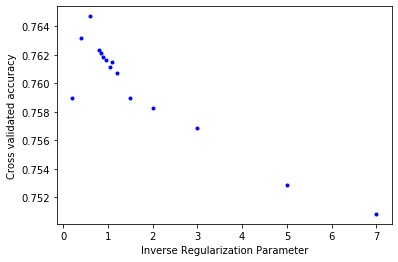

In [0]:
# Looking at CV results mean acc for all C
# Made a plot to show why its not worth tuning C anymore.
%matplotlib inline 
SVC_20_cplot = Pipeline([
                         ('vect', CountVectorizer()),
                         ('tfidf', TfidfTransformer()),
                         ('clf', LinearSVC(penalty='l2',loss='squared_hinge',dual=True))
])
params = {'clf__C': (0.2, 0.4, 0.6, 0.8, 0.85, 0.9, 0.95, 1.05, 1.1, 1.2, 1.5, 2, 3, 5, 7)}
SVC_20_cplot_gs = GridSearchCV(SVC_20_cplot, params, n_jobs=-1)
SVC_20_cplot_gs.fit(twentyTrain.data, twentyTrain.target) 
cs = []
cvAccs = []
for p, r in zip(SVC_20_cplot_gs.cv_results_['params'], SVC_20_cplot_gs.cv_results_['mean_test_score']):
    print(p,r)
    cs.append(p['clf__C'])
    cvAccs.append(r)
fig = plt.figure()
plt.plot(cs, cvAccs, 'b.')
plt.xlabel('Inverse Regularization Parameter')
plt.ylabel('Cross validated accuracy')
plt.savefig('imdbCTunePlot', dpi=400)

In [0]:
# Tuning Count Vec and tfidf, 20 newsgroups
SVC_20_feat_tune = Pipeline([
                        ('vect', CountVectorizer()),
                        ('tfidf', TfidfTransformer()),
                        ('clf', LinearSVC(penalty='l2', dual=True, loss='squared_hinge'))                            
])
params = {'vect__ngram_range': ((1,1), (1,2)),
         'vect__max_df': (0.2, 0.4, 0.6, 0.8, 1.0),
          'tfidf__sublinear_tf': (True, False),
         'clf__C': (0.01, 0.1, 1.0, 10, 20)}

SVC_20_feat_tune_gs = GridSearchCV(SVC_20_feat_tune, params, return_train_score=True)
SVC_20_feat_tune_gs.fit(twentyTrain.data, twentyTrain.target) 

for param_name in sorted(params.keys()):
  print("%s : %r" % (param_name, SVC_20_feat_tune_gs.best_params_[param_name]))
print('Train time for best params:', SVC_20_feat_tune_gs.cv_results_['mean_fit_time'][SVC_20_feat_tune_gs.best_index_])
print('Train acc for best params:', SVC_20_feat_tune_gs.cv_results_['mean_train_score'][SVC_20_feat_tune_gs.best_index_])
print('CV acc for best params:', SVC_20_feat_tune_gs.best_score_)

# Check how the best performs:
SVC_20_feat_tune_best = Pipeline([
                         ('vect', CountVectorizer(ngram_range=SVC_20_feat_tune_gs.best_params_['vect__ngram_range'],
                                                  max_df=SVC_20_feat_tune_gs.best_params_['vect__max_df'])),
                         ('tfidf', TfidfTransformer(sublinear_tf=SVC_20_feat_tune_gs.best_params_['tfidf__sublinear_tf'])),
                         ('clf', LinearSVC(penalty='l2',
                                           loss='squared_hinge',
                                           dual=True,
                                           C=SVC_20_feat_tune_gs.best_params_['clf__C']))
])

start = time.time()
SVC_20_feat_tune_best.fit(twentyTrain.data, twentyTrain.target)
print('Train time:', time.time()-start)
# Train acc
trainPreds = SVC_20_feat_tune_best.predict(twentyTrain.data)
print('Train acc:', accuracy_score(trainPreds, twentyTrain.target))

In [0]:
# Best SVC on 20 newsgroups with feature tuning
SVC_20_best = Pipeline([
                        ('vect', CountVectorizer(ngram_range=(1,2), max_df=0.2)),
                        ('tfidf', TfidfTransformer(sublinear_tf=True)),
                        ('clf', LinearSVC(penalty='l2', C=20.0, dual=True, loss='squared_hinge'))
])
SVC_20_best.fit(twentyTrain.data, twentyTrain.target)
SVC20BestPreds = SVC_20_best.predict(twentyTest.data)
print("SVC 20 Newsgroups best classifier accuracy: ", accuracy_score(twentyTest.target, SVC20BestPreds))

SVC 20 Newsgroups best classifier accuracy:  0.7048592671269251


In [0]:
# Performing first two steps of pipeline separately to be able to study them.
# First, look at new feature design
CountVec = CountVectorizer(max_df=0.2, ngram_range=(1,2))
twentyTrain_count = CountVec.fit_transform(imdbTrain.data)
tfidfVec = TfidfTransformer(sublinear_tf=True).fit(twentyTrain_count)
twentyTrain_tfidf = tfidfVec.transform(twentyTrain_count)
print('New design shape:', twentyTrain_tfidf.shape)
# Now, look at default
CountVec_def = CountVectorizer()
twentyTrain_count_def = CountVec_def.fit_transform(twentyTrain.data)
tfidfVec_def = TfidfTransformer().fit(twentyTrain_count_def)
twentyTrain_tfidf_def = tfidfVec_def.transform(twentyTrain_count_def)
print('Default shape:', twentyTrain_tfidf_def.shape)

New design shape: (25000, 1513704)
Default shape: (11314, 101631)
